In [1]:
import os
n = 4
experiment_path = f'./data/DWA param Experiment #{n}'

if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)
else:
    raise Exception(f"warning almost deleted old run #{n}")

In [2]:
from map_maker import cluttered_map, save_map
from Turtlebot_Kinematics import unicycleKin
from environment import Environment, load_ENV
from Runner import ControllMode, Runner
from dwa_controller import DWA_Controller

kinematic = unicycleKin()
run_len = 15
dt = 0.16
max_index = None
dwa_horizon = 5.0

# map parameters
map_obs = 8
map_size = 50
map_unknown = True
map_name = f"cluttered_{map_obs}obs_{map_size}x{map_size}_{'unknown' if map_unknown else 'known'}"

'''#param lists
obst_params = [4]*9
goal_params = [1,2,4]*3 #heading actually
speed_params = [1]*3 + [2]*3 + [4]*3
param_list = list([(obst_params[i], goal_params[i], speed_params[i]) for i in range(9)])'''

#param lists
obst_params = [4]*9
goal_params = [1/4, 1/3, 1/2]*3 #heading actually
speed_params = [1]*3 + [2]*3 + [4]*3
param_list = list([(obst_params[i], round(goal_params[i] * speed_params[i], 2), speed_params[i]) for i in range(9)])

pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:

for i in range(run_len):
    run_path = f"{experiment_path}/map {i+1}"
    if not os.path.exists(run_path):
        os.makedirs(run_path)
        
    run_map = cluttered_map(map_obs, map_size, map_unknown)
    map_path = f"{run_path}/{map_name}"
    save_map(run_map, map_name, run_path)

    for obst, goal, speed in param_list:
        # run and save MultiPSO data
        DWA_ENV = Environment.from_dict(run_map, kinematic, record=True)
        DWA_controller = DWA_Controller(20, kinematic, virtual_dt=dwa_horizon)
        DWA_Controller.dist_koeff = -obst
        DWA_Controller.heading_koeff = goal
        DWA_Controller.speed_koeff = speed
        if max_index is None:
            max_index = DWA_ENV.goal_travel_time / dt + 200
        else: max_index = max(max_index, DWA_ENV.goal_travel_time / dt + 200)
        DWA_Runner = Runner(
            DWA_ENV, 
            ControllMode.DWA, 
            DWA_controller, 
            max_step = max_index,
            dt = dt,
            save_path= f"{run_path}/{obst}_{goal}_{speed}"
        )
        DWA_Runner.loop()



# 1
best: 1.2499298855490708 (15.0, -0.047368421052631615)
is unyKin
stepping (15.0, 0.047368421052631615)
offset [0. 0. 0.]
# 2
best: 1.2499661438992375 (15.0, 0.047368421052631615)
is unyKin
stepping (15.0, -0.047368421052631615)
offset [0. 0. 0.]
# 3
best: 1.2499340074414131 (15.0, 0.047368421052631615)
is unyKin
stepping (15.0, -0.047368421052631615)
offset [0. 0. 0.]
# 4
best: 1.2499630462230353 (15.0, -0.047368421052631615)
is unyKin
stepping (15.0, 0.047368421052631615)
offset [0. 0. 0.]
# 5
best: 1.2499298855490708 (15.0, -0.047368421052631615)
is unyKin
stepping (15.0, 0.047368421052631615)
offset [0. 0. 0.]
# 6
best: 1.2499660751071844 (15.0, 0.047368421052631615)
is unyKin
stepping (15.0, -0.047368421052631615)
offset [0. 0. 0.]
# 7
best: 1.2499341982043974 (15.0, 0.047368421052631615)
is unyKin
stepping (15.0, -0.047368421052631615)
offset [0. 0. 0.]
# 8
best: 1.2499628116121446 (15.0, -0.047368421052631615)
is unyKin
stepping (15.0, 0.047368421052631615)
offset [0. 0. 0.]


In [4]:
import numpy as np

max_index = int(np.ceil(max_index))
print("Max_index:", max_index)


Max_index: 430


In [5]:
import pandas
from pandas import DataFrame
import matplotlib.pyplot as plt

In [6]:
def fill_df(df, length, di):
    index = df.index[-1]
    last_loc = df.iloc[-1]
    while len(df) < length:
        index += di
        df.loc[index] = last_loc
    return df

def build_loc(goal_dists, obst_dists):
    return {
        "goal_dists": goal_dists,
        "obst_dists": obst_dists
    }

In [7]:

data_frames = list([DataFrame(columns=["goal_dists", "obst_dists"]) for _ in param_list])

def append_to_total_df(total_df, file_name, max_index, dt):
    df = pandas.read_hdf(file_name)
    goal_dists = fill_df(df["goal_dist"], max_index, dt)
    obst_dists = fill_df(df["obst_dist"], max_index, dt)
    total_df.loc[i] = build_loc(goal_dists, obst_dists)

for i in range(run_len):
    for df, params in zip(data_frames, param_list):
        obst, goal, speed = params
        append_to_total_df(df, f"{experiment_path}/map {i+1}/{obst}_{goal}_{speed}.h5", max_index, dt)
    

In [8]:
import numpy as np

def get_eval_arrays(total_df, max_index):
    # print(total_df.iloc[0])
    avg_goal = list([np.average([total_df.iloc[i]["goal_dists"].iloc[j] for i in range(run_len)])for j in range(max_index)])
    avg_obst = list([np.average([total_df.iloc[i]["obst_dists"].iloc[j] for i in range(run_len)])for j in range(max_index)])
    min_obst = list([np.min([total_df.iloc[i]["obst_dists"].iloc[j] for i in range(run_len)])for j in range(max_index)])
    return avg_goal, avg_obst, min_obst


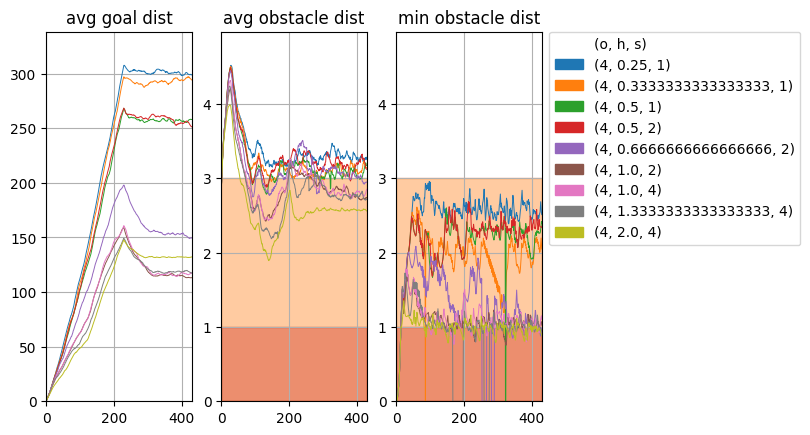

In [9]:
from matplotlib import colormaps
import matplotlib.patches as mpatches

def plot_eval_row(axs, total_df, color=None):
    lw = 0.7
    avg_goal, avg_obst, min_obst = get_eval_arrays(total_df, max_index)
    axs[0].plot(avg_goal, color=color, lw=lw)
    axs[0].set_ylim(top = max(axs[0].get_ylim()[1], max(avg_goal) * 1.1))

    xs = list(range(max_index))
    alpha = 0.05

    axs[1].fill_between(xs, [3]*len(avg_obst), 0.0, linestyle="-", color="tab:orange", alpha=alpha)
    axs[1].fill_between(xs, [1]*len(avg_obst), 0.0, linestyle="-", color="tab:red", alpha=alpha)
    axs[1].plot(avg_obst, color=color, lw=lw)
    axs[1].set_ylim(top = max(axs[1].get_ylim()[1], max(avg_obst) * 1.1))

    axs[2].fill_between(xs, [3]*len(min_obst), 0.0, linestyle="-", color="tab:orange", alpha=alpha)
    axs[2].fill_between(xs, [1]*len(min_obst), 0.0, linestyle="-", color="tab:red", alpha=alpha)
    axs[2].plot(min_obst, color=color, lw=lw) 
    axs[2].set_ylim(top = axs[1].get_ylim()[1])
    for ax in axs:
        ax.set_ylim(bottom = 0.0)
        ax.set_xlim(0,max_index)
        ax.grid()

def get_color(i):
    step = 1 / 10
    return colormaps["tab10"]((i + 0.5) * step)

patches = [mpatches.Patch(color="white", label = "(o, h, s)")]

fig, ax_row = plt.subplots(1,3)
for i,df, params in zip(range(len(param_list)),data_frames, param_list):
    plot_eval_row(ax_row, df, color = get_color(i))
    patches.append(mpatches.Patch(color= get_color(i), label = f"{params}"))
    
#ax_row[0].set_ylabel(kin_label)
ax_row[0].set_title("avg goal dist")
ax_row[1].set_title("avg obstacle dist")
ax_row[2].set_title("min obstacle dist")
ax_row[2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.savefig(f"param_dwa_plot_{n}.png", bbox_inches="tight")

In [10]:
df = pandas.read_hdf("data\Map Experiment #2\9\DWA_data.h5")
print(df)
max_index

          robo_x      robo_y  robo_deg      goal_x  goal_y   goal_dist  \
0.0    50.000000  300.000000  0.000000   50.000000   300.0    0.000000   
0.1    51.542745  299.996242 -0.004872   51.363636   300.0    0.179148   
0.2    53.018691  299.999993 -0.009533   52.727273   300.0    0.291418   
0.3    54.449510  300.010400 -0.014051   54.090909   300.0    0.358752   
0.4    55.960577  300.028028 -0.018823   55.454545   300.0    0.506807   
...          ...         ...       ...         ...     ...         ...   
56.3  279.024862  305.335500 -0.226861  550.000000   300.0  271.027660   
56.4  279.102567  305.357246 -0.134841  550.000000   300.0  270.950400   
56.5  279.183546  305.364430 -0.227553  550.000000   300.0  270.869579   
56.6  279.258533  305.385340 -0.138776  550.000000   300.0  270.795021   
56.7  279.340058  305.392869 -0.232144  550.000000   300.0  270.713663   

      obst_dist  
0.0    3.125000  
0.1    3.221422  
0.2    3.313668  
0.3    3.403094  
0.4    3.497536  
...

430